# XY-calibration (QSO)

In [19]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    import os
    os.chdir("/Users/Vincent/Nextcloud/LAM/FIREBALL/FireBallPipe")
else:
    drive.mount("/content/gdrive", force_remount=True)
    ! cd /content/gdrive/MyDrive/FIREBall-2/FB2_2023/instrument_alignment_focusing/XY_calibration/FireBallPipe

# cd /content/gdrive/MyDrive/FIREBall-2/FB2_2023/instrument_alignment_focusing/XY_calibration
# ! git clone https://github.com/vpicouet/FireBallPipe.git


| #  | Name                               | Done                     |       Comment               |
|----|------------------------------------|--------------------------|-----------------------------|
| 1  | Have a mask-detector mapping       | <input type="checkbox">  |  And send region file to zeren |
| 2  | Use the previous XY mapping        | <input type="checkbox">  | of the same mask, if never done do a new one   |
| 2.a  |Add mask rotation for F2       | <input type="checkbox">  |                             |
| 3  | Reset magnification/offset/angle   | <input type="checkbox">  |                             |
| 4  | Be sure of the slits path          | <input type="checkbox">  |  Use only regular slits, big moves, do not use slits that are seen with one line or in shadow   |
| 4.a  | Decide to use or not hysteresis compensation          | <input type="checkbox">  |  Adds ~1h in total + slight code complexity but might improve results by <1''  |
| 5  | Account from Zeren offset          | <input type="checkbox">  |                             |
| 6  | Add slits path in google drive     | <input type="checkbox">  |                             |
| 7  | Add CNES moves to google drive     | <input type="checkbox">  |                             |


In [36]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2
from functools import reduce
import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model
from guider2UV.MaskAstrometry import LocalScienceMaskProjector
from Calibration.mapping import Mapping

# encoder gains 2022:
Elg = 1.0063 #2023 FTS #0.9969 # 2023 #1.0090 2022 # Elg = 1.00379 # 2018
CEg =  1.0272 #2023 FTS #1.018  # 2023 #1.0187 2022 # CEg = 1.02928 # 2018
print("After calibration of the encoders, El is %0.5f ''/inc and Ce is %0.5f ''/inc" %(Elg*0.092,CEg*0.01))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
After calibration of the encoders, El is 0.09258 ''/inc and Ce is 0.01027 ''/inc


## initialization from last xy calib
---------------------------------
This was actually a mistake, it should slways be done from the same mask (same field center), or create a new G2UV object

In [37]:
# prerequisites:
Field = "QSObright"
previous_xy_mapping = "Calibration/Mappings/2018/XY/Guider2UV_F3_nogamma.new.pkl"
mask_det_map_file = "Calibration/Mappings/2023/mask_to_det_mapping/mapping-mask-det-w-0-QSObright_230820_good.pkl"
target_filename = 'Calibration/Targets/2022/targets_%s.csv'%(Field)
Hysteresis_compensation = False
# if input("Are you sure that you want to use Hysteresis_compensation = %s? (y/n)"%(Hysteresis_compensation))!="y":
#     raise ValueError("Please be verify the value of Hysteresis_compensation")


In [38]:
# # load model from previous XY calib 
# G2UV = Guider2UV(filename=previous_xy_mapping)
# #changer de centre 
# G2UV.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(0.1038940*u.deg, 1.594590*u.deg), rotation=(90-100)*u.deg, gamma=1)#QSO1
		
	
# # eventually reset the guider-scmask rotation to 0 and magnification correction to 0.
# G2UV.mask_rotation = 0.0*u.arcmin
# G2UV.FieldP.gamma = 1. 
# G2UV.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
# G2UV.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
# print(G2UV)

# # if you already know the approx angular distance between guidercenter and FOVcenter, set it:
# # G2UV.FOV_center_guider_coord = coordinates.SkyCoord(delta_x*u.deg, # x guider axis (x axis in guider local frame, see XYcalib figure)
# #                                                    delta_y*u.deg, # y guider axis (y axis guider local frame, see XYcalib figure)
# #                                                    frame = G2UV.GuiderP.localframe)

# load targets
F1 = Table.read(target_filename, format='ascii')

# load mask-UVdetector mappings
mask_det_map = Mapping(mask_det_map_file)

# if input("Are you sure that these values make sense for %s: Theta=%s, center=%s? (y/n)"%(Field, G2UV.FieldP.rotation, G2UV.FieldP.center))!="y":
#     raise ValueError("Please verify the initialization mapping")
star_target_path = "Calibration/Targets/2022/GuidingStars/QSO_guidingstars.csv"

F1_stars = Table.read(star_target_path).to_pandas()

stars =  [26,27,28] #QSOV 1
selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))




## Alternative initialisation for new fields:
---------------------------------------

In [39]:

f_ra, f_dec, f_rot = 11.866,	3.244, 0
Field_center=coordinates.SkyCoord(f_ra * u.deg, f_dec * u.deg)
# get FOVcenter & guider wcs from another field
#  put pkl from a functionning mapping from another field
G2UVother = Guider2UV(filename=previous_xy_mapping)
FOVcenter = G2UVother.FOV_center_guider_coord
guider_wcs = G2UVother.GuiderP.w
G2UV = Guider2UV(Field_center=Field_center,
                 Field_rotation= f_rot * u.deg,
                 Field_gamma=1.0,  # platescale correction (need to update the polynomial in the MaskAstrometry.py)
                 FOVcenter_guider_coord=FOVcenter,
                 guider_wcs = guider_wcs,
                 )
                 


FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>): (lon, lat) in deg
    (0.18212015, -0.00658703)>
FOV center pixel position in guider [array(1356.48459465), array(515.54397687)]


## 1-  Rotate mask carousel
## 2- Diffuse UV image

Copy the offset from [this spreadsheet step "Compute offsets with previous diffuse illumination image"](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [40]:
# This offset in X and Y should be positive if the slit position in tghe new image appears to be shifted towards the top right
diffuse_offset = np.array([0.6,1.4])
diffuse_offset = np.array([0,0])
G2UV.set_detector_mapping(mask_det_map, offsets = diffuse_offset+1) #+1 offset is to account for DS9 vs python offset
direct_map = lambda w, x, y: mask_det_map.map(w, x, y) + diffuse_offset
inv_map = lambda w, x, y: mask_det_map.inv_map(w, x - diffuse_offset[0], y - diffuse_offset[1])

## 3 - Set guider at best focus          
## 4 - Align siderostat frames           
## 5 - Go to guider reference            
## 6 - Set UV/guider best focus offset   
## 7 - Rotate mask carousel              
## 8 - Through focus in UV               
## 9 - Note open-mask guider ref point   
    

## 10 - Go through the list of slits      

['23', '36', '2', '13', '32', '11',"4"]

Here we struggled to find the good path because of faint 202/206 lines and of shadow of fiber holder

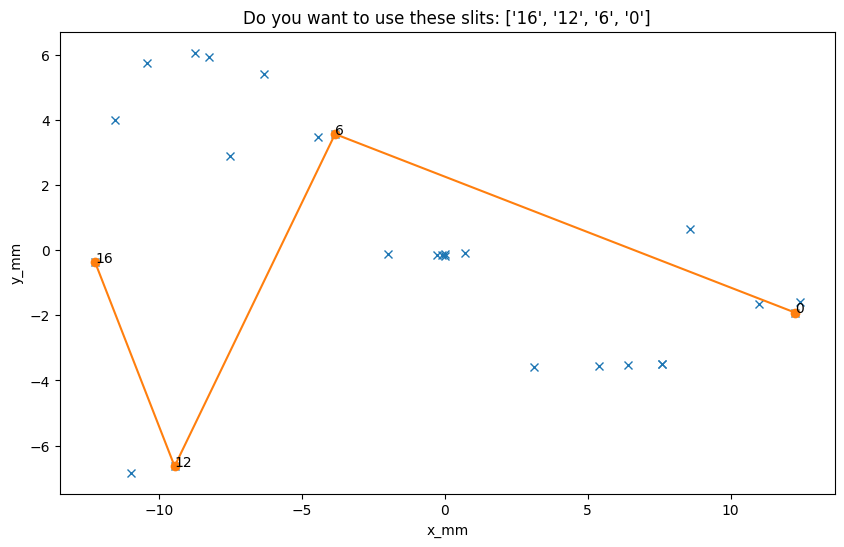

      RA            DEC     
-------------- -------------
   11.74227644   2.967784983
   11.91243088   2.993149037
   11.94680242   2.904172905
11.57508873526 3.23877002923
       11.6413          3.09
11.77466105461 3.33188467509
12.15660518316 3.20191018404


In [41]:
slits =[  "16","12","6","0"]# short pass
F1['Internal-count'] = F1['Internal-count'].astype(str)

F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))
ra,dec = "RA", "DEC"
x,y = "x_mm","y_mm"
plt.figure(figsize=(10,6))
plt.plot(F1[x],F1[y],"x")
plt.plot(selected_slits[x],selected_slits[y],"-o")
for s in selected_slits:
    plt.text(s[x],s[y],s["Internal-count"])
plt.xlabel("x_mm")
plt.ylabel("y_mm")
plt.title("Do you want to use these slits: %s"%(slits))
plt.show()

selected_slits = selected_slits['Internal-count',x,y,ra,dec]
slit_path = selected_slits# vstack((selected_slits,selected_slits[::-1]) )
slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path
stars_and_slits = vstack([selected_stars["RA","DEC"],selected_slits["RA","DEC"]])
print(stars_and_slits)

The slits table has been copied. Add it to the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [42]:
moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation,Elg=Elg,CEg=CEg)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])#,dtype=[("EL",float),("CE",float),("UV_image",float)])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
try:
    moves.to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves
if ~Hysteresis_compensation:
    print("Carefull, with Hysteresis_compensation==%s the last move to return to the guider is not given. You just need to do -∑all moves"%(Hysteresis_compensation))
    print("You should then add EL=%0.4f and CE=%0.4f"%(moves.sum(axis=0)[0],moves.sum(axis=0)[1]))


slit position in mm on mask: [-12.23000019  -0.36216972]
slit position in mm on mask: [-9.44640593 -6.63744582]
slit position in mm on mask: [-3.83527558  3.56907853]
slit position in mm on mask: [12.25014337 -1.91624601]

targets local coords in siderostat local frame:
EL: 310.4 arcsec ; CE: -496.7 arcsec
EL: 44.3 arcsec ; CE: -380.9 arcsec
EL: 476.9 arcsec ; CE: -147.6 arcsec
EL: 244.5 arcsec ; CE: 520.7 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)
Carefull, with Hysteresis_compensation==False the last move to return to the guider is not given. You just need to do -∑all moves
You should then add EL=244.4700 and CE=520.6630


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Copy below the observed slits position from the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [43]:
# fig, (ax0,ax1) = plt.subplots(1,2)
# ax0.plot(slits_coord_obs_det[:,1]-slits_coord_obs_det[:,1].mean(),slits_coord_obs_det[:,0]-slits_coord_obs_det[:,0].mean(),"o")
# ax1.plot(-46*selected_slits["x_mm"],46*selected_slits["y_mm"],"o")
# ax1.plot(slits_coord_obs_det[:,1]-slits_coord_obs_det[:,1].mean(),slits_coord_obs_det[:,0]-slits_coord_obs_det[:,0].mean(),"o")


In [44]:

slits_coord_obs_det = np.array([
[ 1668	,1899 ],
[ 1857	,513  ],
[ 1566	,1406 ],
[ 1645	,203   ],
]) 


valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave = 0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs

# if input("Are you sure you computed the barycenter on the line %s? Remember that it's better to use 206 line to probe a bigger part of the detector. It might require gain and longer exposure though. Be sure to always compute the centroid on the same line. (y/n)"%(obs_wave))!="y":
#     raise ValueError("Please change obs_wave parameter (c)")


wave:  0.20619


[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.17954849, 0.25815495)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.24907153, -0.16217631)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.14669978, 0.10736014)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.17290217, -0.25754333)]>]

### look at siderostat frame hysteresis 

## 11- Note open-mask guider ref point
## 12- Update model with observed slit positions

Fitting rotation and translation
theta: -446.97397354472935 arcmin
dx: -165.6885096161459 arcsec
dy: 378.30335758501934 arcsec
variances: [1.98141675 0.52182974 0.58938476]

residuals in arcsec: [[ -11.34863139  205.996126  ]
 [ 743.62972312 -999.70297315]
 [-557.94469471  336.88158012]
 [-174.33639703  456.82526703]]
max residual in EL,CE 743.6, 999.7 arcsec
mean residual in EL,CE 473.0, 584.0 arcsec
After updating:
    mask_rotation: -7.449566225745489 deg
    FOV center in guider: 1178.9122705789166 x 834.4234542253157 pix = 486.8608310245724 arcsec x 269.34506365331765 arcsec arcsec
    mask_magnification correction: 1.0  
    
[-449.65474277 -437.90236011 -774.27894988  604.13226516   37.56863473
  845.94162479  199.67421828] [ 843.43724726  219.83728949  137.89148512 1317.38134082 1149.16065054
  556.4712766  -755.5186503 ]
[-449.65474277 -437.90236011 -774.27894988  604.13226516   37.56863473
  845.94162479  199.67421828] [ 843.43724726  219.83728949  137.89148512 1317.38134082 

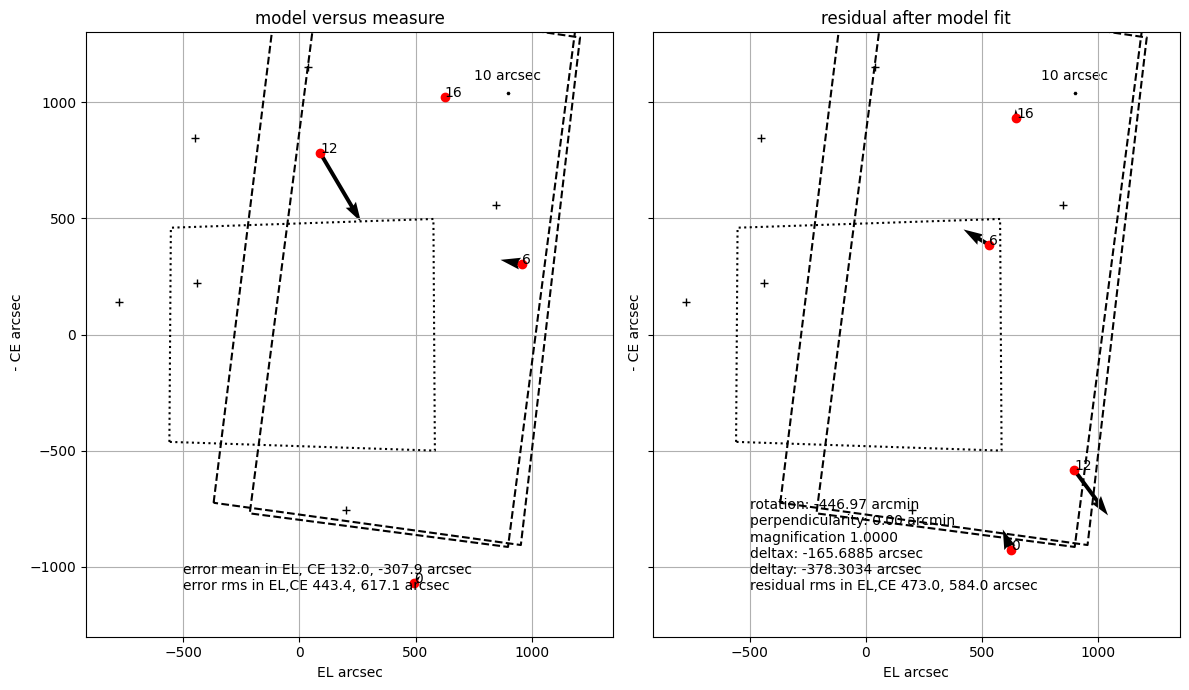


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            


In [45]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, plot=True, figsize=(12,7), labels=slits,gamma=False,selected_stars=stars_and_slits)


### check updating without fitting magnification


Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (11.866, 3.244)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.424026537  36.4349969891  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024648264068189  0.00024664057706659  
NAXIS : 0  0

    mask_rotation: -7.449566225745489 deg
    FOV center in guider: 1178.9122705789166x834.4234542253157 pix

Fitting rotation, translation and magnification
gamma: 1.5052142648847395
theta: -446.97397354473003 arcmin
dx: -439.2128957861447 arcsec
dy: 247.38902172996293 arcsec
variances: [5.76370770e-04 1.98141675e+00 6.08013714

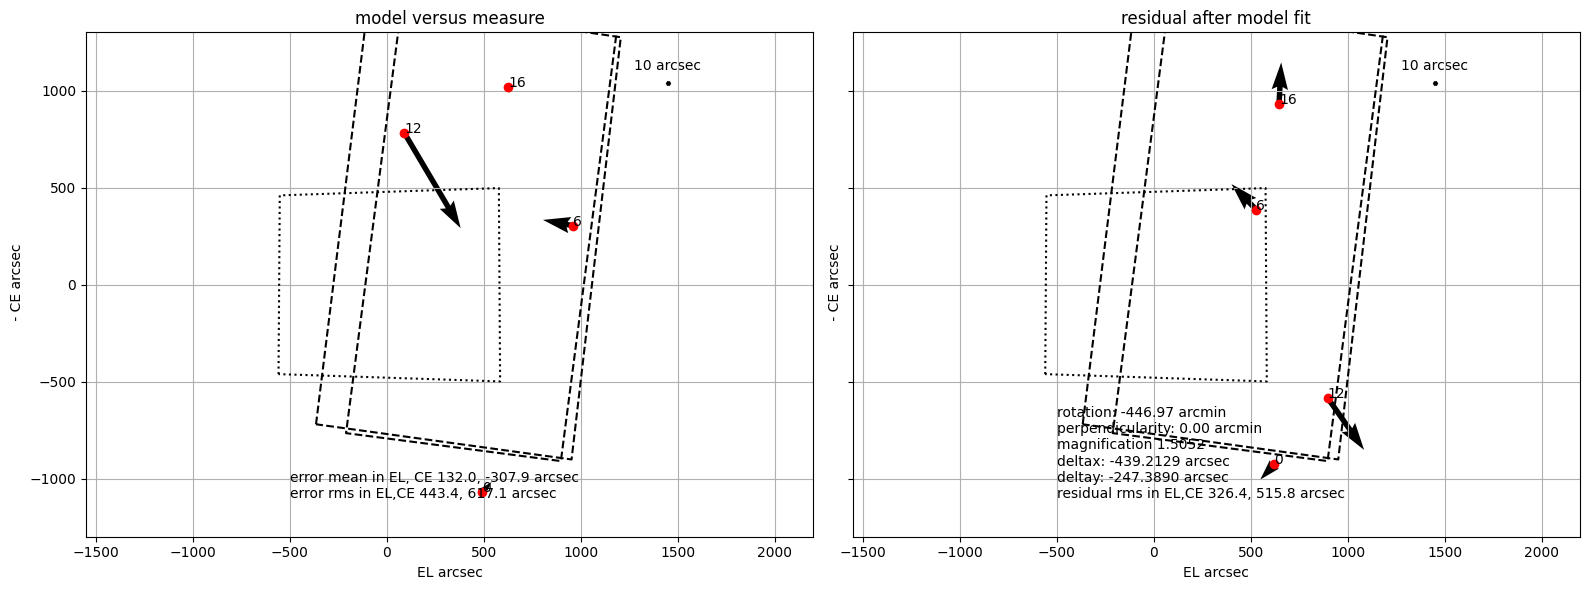


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            


In [47]:
G2UVtest=G2UV.copy()
G2UVtest.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UVtest.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
G2UVtest.FieldP.gamma = 1.
print(G2UVtest)
G2UVcor_test, residuals = G2UVtest.update_model(slits_coord_valid, slits_coord_obs, labels=slits, plot=True, figsize=(16,6), gamma=True,inplace=False)


### sVerify what magnification it predicts
### save corrected model for future use (eg redo the calib on same field)

# Another try in open mask

In [48]:
slits =[  '7',"3","11","14"]# short pass
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))

# selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))

moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation,Elg=Elg,CEg=CEg)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
try:
    moves.to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves


slit position in mm on mask: [-4.43113008  3.48782333]
slit position in mm on mask: [ 5.39 -3.55]
slit position in mm on mask: [-8.74712732  6.06767877]
slit position in mm on mask: [-10.98191919  -6.8357052 ]

targets local coords in siderostat local frame:
EL: 414.0 arcsec ; CE: -296.1 arcsec
EL: 61.9 arcsec ; CE: 73.4 arcsec
EL: 547.4 arcsec ; CE: -461.7 arcsec
EL: 12.4 arcsec ; CE: -624.6 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


,EL,CE,UV_image,EL_abs,CE_abs
0,413.997858,-296.115864,True,413.997858,-296.115864
1,-352.121850,369.491766,True,61.876009,73.375902
2,485.505262,-535.027561,True,547.381271,-461.651659
3,-534.941486,-162.905843,True,12.439785,-624.557502


wave:  0.20619
Fitting rotation and translation
theta: -2338.2297683725674 arcmin
dx: -517.2768719879889 arcsec
dy: 848.7956814058783 arcsec
variances: [2.45015984 0.69251813 0.62285072]

residuals in arcsec: [[ -279.14091011   818.68162529]
 [  -77.00562026   513.77989189]
 [ -519.65860244  -222.99118475]
 [  875.80513281 -1109.47033242]]
max residual in EL,CE 875.8, 1109.5 arcsec
mean residual in EL,CE 529.4, 744.1 arcsec
After updating:
    mask_rotation: -46.420062365288274 deg
    FOV center in guider: 822.7372750750226 x 1417.5387844467414 pix = 152.78263182730558 arcsec x 786.9957934209074 arcsec arcsec
    mask_magnification correction: 1.0  
    
[ -481.19117093  -885.51557981 -1305.95491715   981.23828306
   252.88832848   735.13686122  -844.86564334] [2037.40797549 1351.71639725 1487.63186807 1847.73611195 2043.83593556
  858.91825931 -134.90791845]
[ -481.19117093  -885.51557981 -1305.95491715   981.23828306
   252.88832848   735.13686122  -844.86564334] [2037.40797549 1351

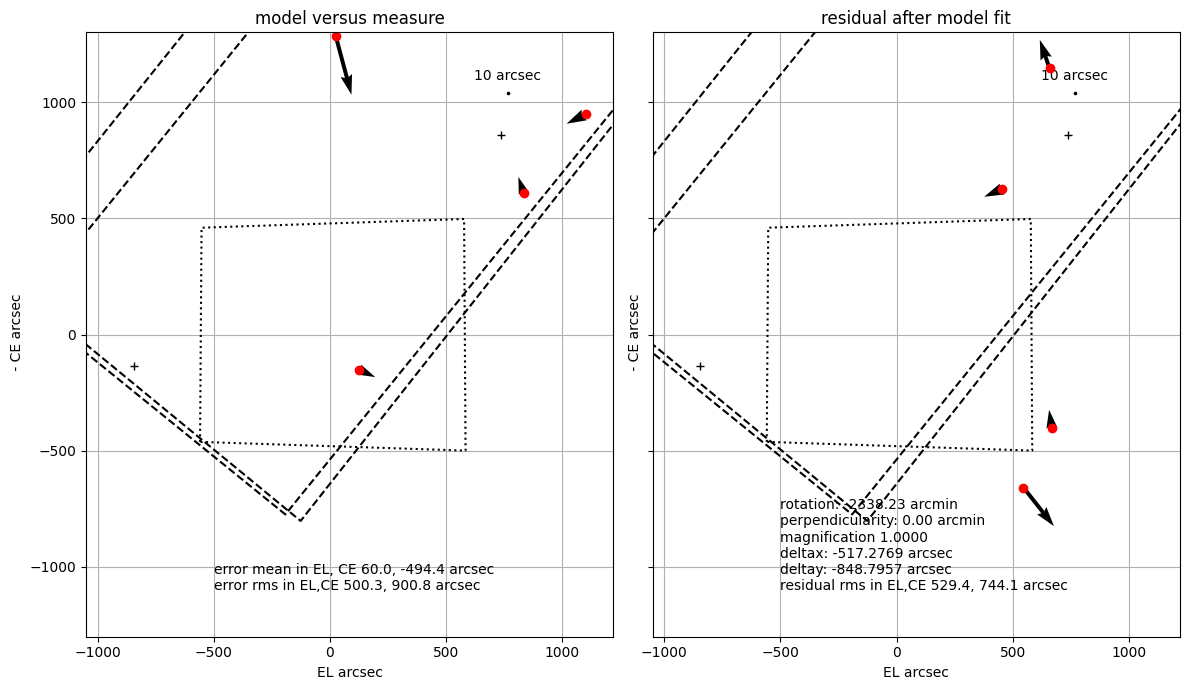


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            


In [49]:
slits_coord_obs_det = np.array([
[  1719	, 1835   ],
[  1875,	443 ],
[  1605	, 1347  ],
[  1810,	199 ]])



valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave =  0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs

slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, plot=True, figsize=(12,7),gamma=False,selected_stars=stars_and_slits)#, labels=slits)#



In [15]:
slits =[  '7',"3","11","14"]# short pass
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))

# selected_stars =Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))

moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation,Elg=Elg,CEg=CEg)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
try:
    moves.to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves


slit position in mm on mask: [-4.43113008  3.48782333]
slit position in mm on mask: [ 5.39 -3.55]
slit position in mm on mask: [-8.74712732  6.06767877]
slit position in mm on mask: [-10.98191919  -6.8357052 ]

targets local coords in siderostat local frame:
EL: 663.9 arcsec ; CE: -317.6 arcsec
EL: -618.6 arcsec ; CE: 27.5 arcsec
EL: 1184.9 arcsec ; CE: -504.5 arcsec
EL: 235.2 arcsec ; CE: -1570.0 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


,EL,CE,UV_image,EL_abs,CE_abs
0,663.870007,-317.602624,True,663.870007,-317.602624
1,-1282.471550,345.143888,True,-618.601542,27.541264
2,1803.532059,-532.021953,True,1184.930517,-504.480689
3,-949.692543,-1065.522914,True,235.237973,-1570.003603


## 13 - Rotate carousel to science mask
## 14 - Note open-mask guider ref point
## 15 - Check corrected model through science mask

slit position in mm on mask: [-4.43113008  3.48782333]
slit position in mm on mask: [ 5.39 -3.55]
slit position in mm on mask: [-8.74712732  6.06767877]
slit position in mm on mask: [-10.98191919  -6.8357052 ]

targets local coords in siderostat local frame:
EL: 663.9 arcsec ; CE: -317.6 arcsec
EL: -618.6 arcsec ; CE: 27.5 arcsec
EL: 1184.9 arcsec ; CE: -504.5 arcsec
EL: 235.2 arcsec ; CE: -1570.0 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


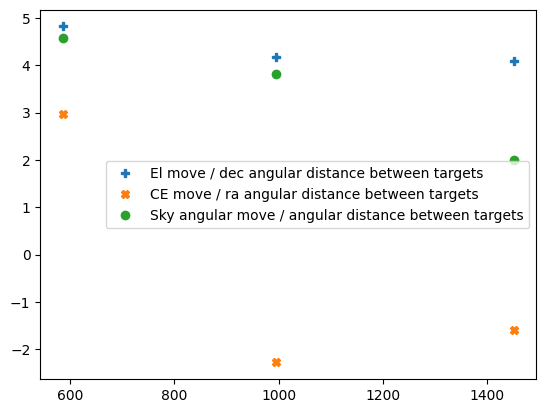

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance,EL,CE,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
16,-12.230000194381756,-0.36216972480346565,11.57508873526,3.23877002923,-237.9798348085261,535.5721052280002,586.064741879125,-1282.4715497792397,345.14388832999816,-2581.1022410856976,709.0636041851482,2676.7256067287963,4.567286539276009,-4.819336585849422,-2.979511288238547
12,-9.44640593475523,-6.637445819890143,11.6413,3.09,-479.4017764535794,-870.7848303240004,994.0283114626292,1803.5320590039446,-532.0219532655453,3629.788621951339,-1092.9859007887362,3790.7761236151055,3.8135494531713054,-4.168410490799171,2.279895391448493
6,-3.835275582367941,3.569078532665707,11.77466105461,3.33188467509,-1372.6746033091042,467.9081677800001,1450.2322641718613,-949.6925431412914,-1065.5229138090472,-1911.351212326163,-2189.0102741293063,2906.0332821742345,2.0038399047987614,-4.084885334219764,1.594704432392253


In [16]:
moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

try:
    moves.to_pandas().to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves

new_cat = slit_path[:-1]
new_cat["EL"] = moves["EL"][1:]
new_cat["CE"] = moves["CE"][1:]

new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
# new_cat.to_pandas().to_clipboard()



plt.figure()
plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
plt.legend()
plt.show()
new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

Here we just wanted to do another try to verify that the least square gives consistent results

wave:  0.20619
Fitting rotation and translation
theta: 1317.030193818019 arcmin
dx: 3330.995425977894 arcsec
dy: -1791.5098178120957 arcsec
variances: [0.98503798 0.70331833 0.59755748]

residuals in arcsec: [[ 3595.62608977  2334.09600164]
 [-2722.88592274  -957.12808522]
 [ -872.74016704 -1376.96791642]]
max residual in EL,CE 3595.6, 2334.1 arcsec
mean residual in EL,CE 2652.3, 1659.3 arcsec
After updating:
    mask_rotation: -24.46955913498796 deg
    FOV center in guider: 3887.20849144344 x -726.0555356701346 pix = 3304.7444744443783 arcsec x -1370.18730118553 arcsec arcsec
    mask_magnification correction: 2.019596796132973  
    


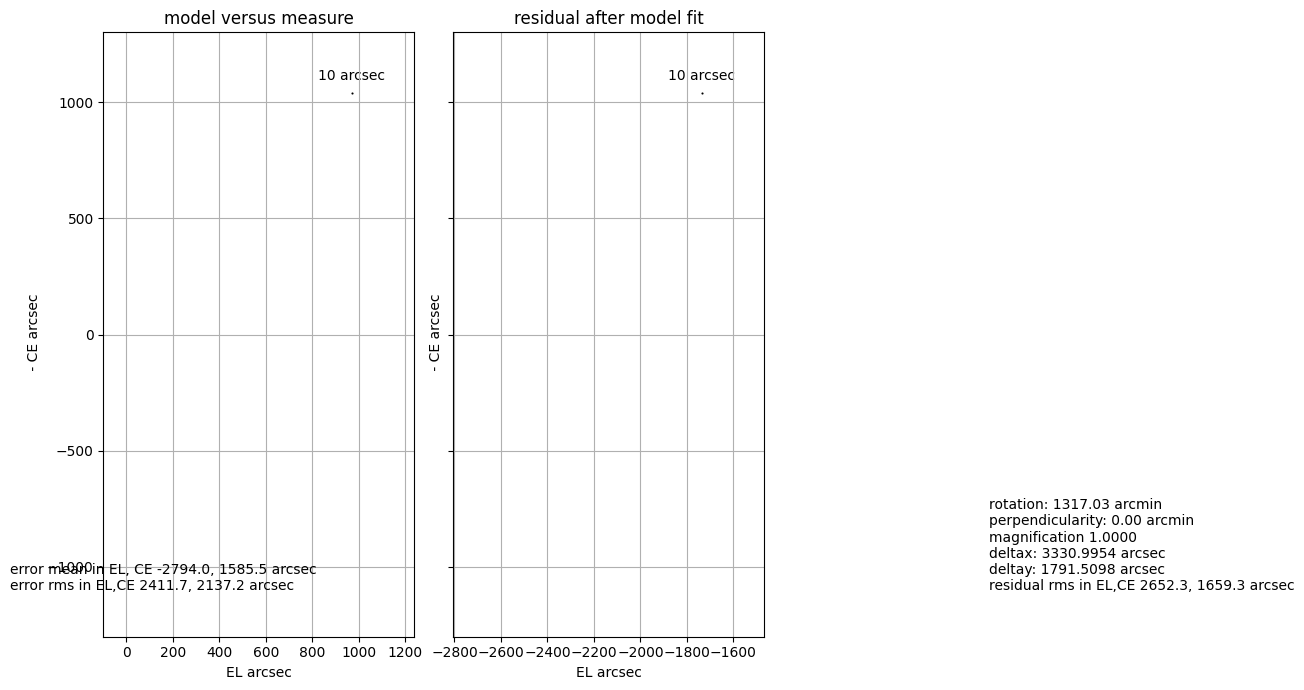


            Left plot verification
            [x]  Error mean give the average of the residuals (=arrows=model-measurements) before model improvement
            This Error mean must be <5" at the last interation
            [x]  Error rms is the rms of the arrows. This might potentiallly due to rotation or bad cutting of the slits
            [x]  Crosses show targets and bright stars position using the updated model. For the final iteration + & o should be gathered on both plots
            Right plot verification
            [x]  Residual rms are residuals between new model and measures after fitting an offset + rotation.
            If should always be <5" even if we are far from the slits
            [x] Rotation should be <1deg, magnification should be 1
            [x] Delta x and y should be close to 0 for the last iteration.
            
            
            
            
slit position in mm on mask: [-4.43113008  3.48782333]
slit position in mm on mask: [ 5.39 -3.55]
sl

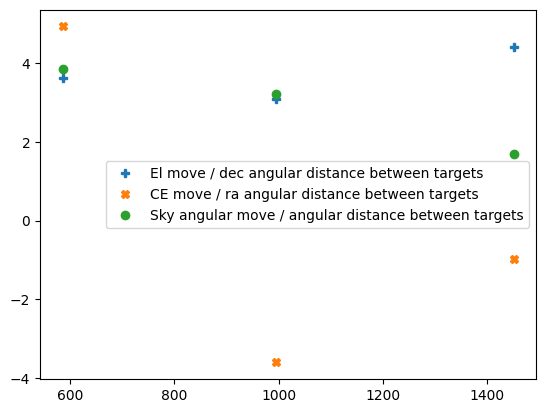

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance,EL,CE,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
16,-12.230000194381756,-0.36216972480346565,11.57508873526,3.23877002923,-237.9798348085261,535.5721052280002,586.064741879125,-960.6659539608862,571.0562997403916,-1933.4362989416795,1173.1780621866606,2261.5310494577225,3.8588416737141986,-3.610039208667505,-4.929737274297112
12,-9.44640593475523,-6.637445819890143,11.6413,3.09,-479.4017764535794,-870.7848303240004,994.0283114626292,1339.9654197605043,-840.9799393380047,2696.814403809991,-1727.7091873759966,3202.778007408641,3.2220189007454145,-3.096992861952549,3.603885659658775
6,-3.835275582367941,3.569078532665707,11.77466105461,3.33188467509,-1372.6746033091042,467.9081677800001,1450.2322641718613,-1023.2956747636761,-650.6716855645559,-2059.4848750293745,-1336.7399108238235,2455.2701561465783,1.6930185714414736,-4.401472376087476,0.9738214050156876


In [17]:
slits_coord_obs_det = np.array([
[ 435.4,	1964.8],
[ 597.6,	1856.9],
[ 744.2,	459.3],
[ 479.6,	1370.5],
]) 


valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave =  0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True, figsize=(12,7),gamma=False)#, labels=slits_valid


moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

try:
    moves.to_pandas().to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves

new_cat = slit_path[:-1]
new_cat["EL"] = moves["EL"][1:]
new_cat["CE"] = moves["CE"][1:]

new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
# new_cat.to_pandas().to_clipboard()



plt.figure()
plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
plt.legend()
plt.show()
new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"



In [18]:
G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO1_XY_230621_Field3.pkl")

Dumping to Calibration/Mappings/2023/XY/QSO1_XY_230621_Field3.pkl


# Again another iteration in open mask? NO

In [19]:
# slits_coord_obs_det = np.array([
# [ 670.6,	221.5 ],
# [ 364.6,	1672.1],
# [ 640.9,	704.2 ],
# [ 594.8,	1854  ],
# [ 515.8,	167.7 ],
# # [ 1738.5	,1903.5  ],
# # [ 1592.6	,1205.5  ],
# # [ 1569.6	,1765.5  ],
# # [ 1788.5,	732.5  ]
# ]) 


# valid = np.isfinite(slits_coord_obs_det[:,0])
# obs_wave =  0.20619
# print("wave: ", obs_wave)
# slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# # slits_valid = slits[valid]
# slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
# slits_coord_obs
# slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
# weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
# G2UVcor, residuals = G2UV.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True, figsize=(12,7))#, labels=slits_valid


# moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
# moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
# print("(They have been copied to clipboard, paste it in the spreadsheet)")
# moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
# moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# try:
#     moves.to_pandas().to_clipboard()
# except Exception as e:
#     print("Could not copy: ", e)
# moves

# new_cat = slit_path[:-1]
# new_cat["EL"] = moves["EL"][1:]
# new_cat["CE"] = moves["CE"][1:]

# new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
# new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
# new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
# new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
# new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
# new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# # new_cat
# # new_cat.to_pandas().to_clipboard()



# plt.figure()
# plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
# plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
# plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
# plt.legend()
# plt.show()
# new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"




## 16 - Note science-mask guider ref point
## 17 - Go through the Star sequence We begin by QSO 5
 [29, 34, 18, 14]
we did not have the time to do this because G2UV was not well

In [20]:
# il faut que le centre soit bien defini à l'arcseconde pres.
# stars = [2, 4, 5, 6, 7]
stars =  [13,14]#[2, 4, 5, 6, 7]
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
selected_stars.to_pandas().to_clipboard()
star_moves





targets local coords in siderostat local frame:
EL: -6646.2 arcsec ; CE: 3236.0 arcsec
EL: -6737.3 arcsec ; CE: 2913.0 arcsec

siderostat moves sequence: 


,EL,CE,Image
0,-6646.189205,3236.046912,1.0
1,-91.082005,-323.008851,1.0


In [21]:
stars_path = vstack((selected_stars,selected_stars[::-1]) )
selected_stars['lon'] = [s.lon.deg*3600 for s in stars_coord]
selected_stars['lat'] =  [s.lat.deg*3600 for s in stars_coord]
print("(They have been copied to clipboard, paste it in the spreadsheet)")
star_moves.to_clipboard()


(They have been copied to clipboard, paste it in the spreadsheet)


In [22]:


stars = [8, 10, 12] #QSO7
#back to guider center
#Load new 
G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(22.42638*u.deg, 0.62279*u.deg), rotation=(90-70)*u.deg, gamma=1)
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
selected_stars.to_pandas().to_clipboard()
G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO1_XY_230621_Field2.pkl")

# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363



Dumping to Calibration/Mappings/2023/XY/QSO1_XY_230621_Field2.pkl


In [23]:
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()




targets local coords in siderostat local frame:
EL: 1187.4 arcsec ; CE: 543.3 arcsec
EL: 1155.3 arcsec ; CE: 725.6 arcsec
EL: 1556.8 arcsec ; CE: 718.1 arcsec

siderostat moves sequence: 


In [24]:



stars = [17, 18, 19, 20, 21] #QSOV 14
#back to guider center
G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(351.8533*u.deg, -1.8553*u.deg), rotation=0*u.deg, gamma=1)

selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO1_XY_230621_Field4.pkl")

# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
selected_stars.to_pandas().to_clipboard()
star_moves


Dumping to Calibration/Mappings/2023/XY/QSO1_XY_230621_Field4.pkl

targets local coords in siderostat local frame:
EL: 1503.0 arcsec ; CE: 330.9 arcsec
EL: 1536.7 arcsec ; CE: 750.9 arcsec
EL: 1575.0 arcsec ; CE: 771.5 arcsec
EL: 1399.5 arcsec ; CE: 754.0 arcsec
EL: 1302.6 arcsec ; CE: 720.9 arcsec

siderostat moves sequence: 


,EL,CE,Image
0,1503.028928,330.944975,1.0
1,33.689147,419.957828,1.0
2,38.242033,20.596742,1.0
3,-175.462394,-17.492820,1.0
4,-96.898638,-33.111090,1.0


In [25]:
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()


targets local coords in siderostat local frame:
EL: 1503.0 arcsec ; CE: 330.9 arcsec
EL: 1536.7 arcsec ; CE: 750.9 arcsec
EL: 1575.0 arcsec ; CE: 771.5 arcsec
EL: 1399.5 arcsec ; CE: 754.0 arcsec
EL: 1302.6 arcsec ; CE: 720.9 arcsec

siderostat moves sequence: 


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [26]:
#back to guider center
G2UVcor.FieldP = LocalScienceMaskProjector(center=coordinates.SkyCoord(0.03894*u.deg, 1.39459*u.deg), rotation=(90-100)*u.deg, gamma=1)
G2UVcor.save(filename="Calibration/Mappings/2023/XY/QSO1_XY_230621_Field1.pkl")

# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()
selected_stars.to_pandas().to_clipboard()


Dumping to Calibration/Mappings/2023/XY/QSO1_XY_230621_Field1.pkl

targets local coords in siderostat local frame:
EL: 4948.3 arcsec ; CE: -16139.3 arcsec
EL: 4909.7 arcsec ; CE: -15719.3 arcsec
EL: 4944.3 arcsec ; CE: -15692.4 arcsec
EL: 4772.6 arcsec ; CE: -15739.7 arcsec
EL: 4681.8 arcsec ; CE: -15788.9 arcsec

siderostat moves sequence: 


In [27]:
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()


targets local coords in siderostat local frame:
EL: 4948.3 arcsec ; CE: -16139.3 arcsec
EL: 4909.7 arcsec ; CE: -15719.3 arcsec
EL: 4944.3 arcsec ; CE: -15692.4 arcsec
EL: 4772.6 arcsec ; CE: -15739.7 arcsec
EL: 4681.8 arcsec ; CE: -15788.9 arcsec

siderostat moves sequence: 


In [28]:
selection = selected_stars['Internal count',
 'RA',
 'DEC',
 'X',
 'Y',
 'GAIA gband',
 'SDSS gband',
 'SDSS rband',
 'Xguider',
 'Yguider']
# selection=vstack((selection,selection[::-1]))
selection.add_row(["-99",-99,-99,640,540,-99,-99,-99,-99,-99])
selection.to_pandas().to_clipboard()
selection

KeyError: 'X'

The stars table has been copied. Add it to the [stars tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)


## 18 - Through focus guide star 1
## 19 - Track mask to guider changes
------------------------------------------------------